# Урок 9. Python применение продвинутых методов

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats import proportion
#from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.power as smp

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Задание 1
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.\
Mobile Games AB Testing with Cookie Cats

In [2]:
df = pd.read_excel('cookie_cats.xlsx')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


**userid** - уникальный номер, который идентифицирует каждого игрока.

**version** - Был ли игрок поставлен в контрольную группу (gate_30 - ворота 30 уровня) или в группу с перемещенными воротами (gate_40 - ворота 40 уровня).

**sumgamerounds** - количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки.

**retention_1** - Вернулся ли игрок в игру через 1 день после установки.

**retention_7** - Вернулся ли игрок в игру через 7 дней после установки.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [4]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [5]:
df.groupby('userid', as_index=False).agg({'version': pd.Series.nunique}).query('version > 1')

,userid,version


In [6]:
df.duplicated().sum()

0

In [7]:
df['userid'].duplicated().sum()

0

In [8]:
df[['sum_gamerounds', 'retention_1', 'retention_7']].describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


Уберем аномальный выброс в поле sum_gamerounds.

In [9]:
df = df[df['sum_gamerounds'] < 49000]

In [10]:
df['version'].value_counts()

gate_40    45489
gate_30    44699
Name: version, dtype: int64

In [11]:
df['retention_1'].value_counts()

0    50035
1    40153
Name: retention_1, dtype: int64

In [12]:
df['retention_7'].value_counts()

0    73408
1    16780
Name: retention_7, dtype: int64

**Анализ исходных данных показал**:
1. Пустых данных в выборке нет.
2. Количество пользователей в группах gate_30/gate_40 примерно одинаковое, дублей в userid нет - система сплитования трафика отраболала хорошо.
3. Отрицательных (ошибочных) значений в выборке нет.
4. Поле version имеет два значения gate_30/gate_40 - ошибочных значений нет.
5. Поля retention_1 и retention_7 содержит два значения: 0/1 - ошибочных значений нет.

### Метрика: количество раундов, сыгранных каждым игроком в течение первых 14 дней после установки.

Проверим данные на нормальность.

In [13]:
A = df.query('version == "gate_30"')
B = df.query('version == "gate_40"')
n1, n2 = A.shape[0], B.shape[0]

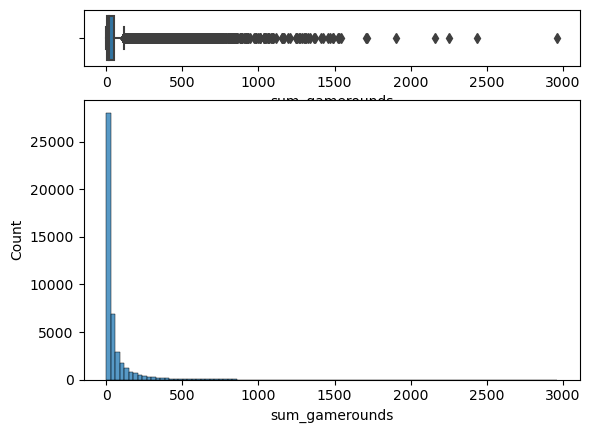

In [14]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(A['sum_gamerounds'], ax=ax[0]);
sns.histplot(A['sum_gamerounds'], bins=100, ax=ax[1]);

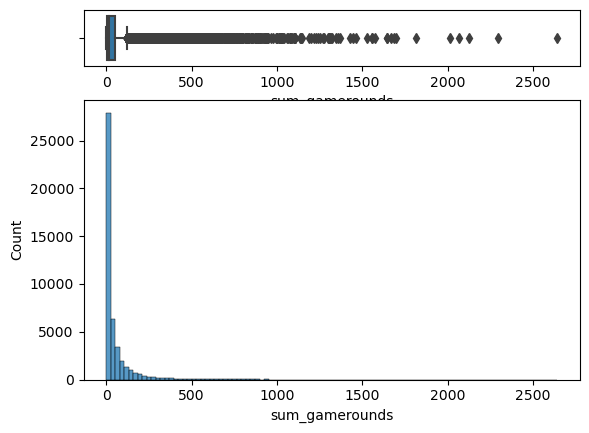

In [15]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(B['sum_gamerounds'], ax=ax[0]);
sns.histplot(B['sum_gamerounds'], bins=100, ax=ax[1]);

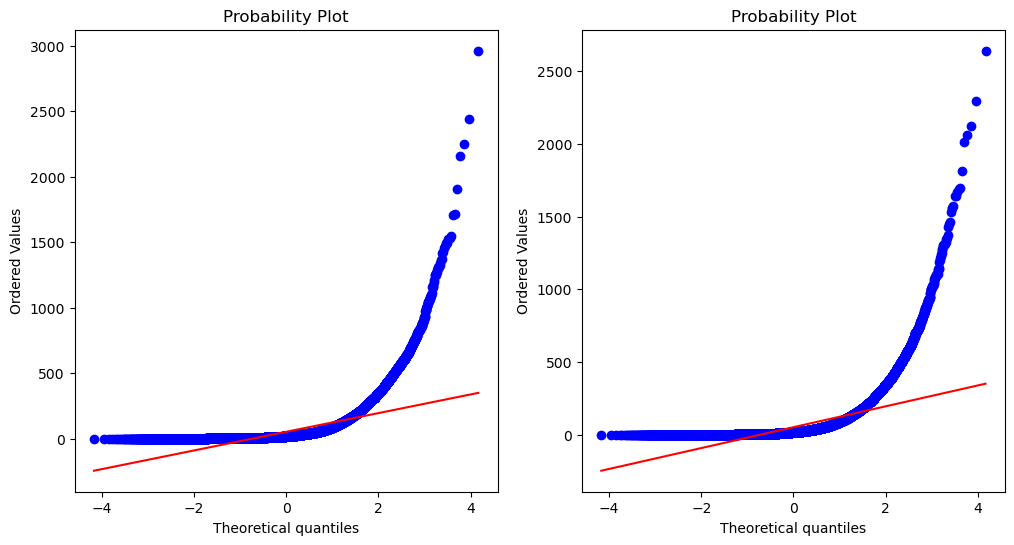

In [16]:
plt.figure(figsize = [6*2, 6])

plt.subplot(1, 2, 1)
norm = stats.probplot(A['sum_gamerounds'], dist="norm", plot=plt)

plt.subplot(1, 2, 2)
norm = stats.probplot(B['sum_gamerounds'], dist="norm", plot=plt)

In [17]:
stats.kstest(A['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8724153079945488, pvalue=0.0)

p-value < 0.05, следовательно предположение о нормальном распределени в группе А (gate_30) **не** верно.

In [18]:
stats.kstest(B['sum_gamerounds'], 'norm')

KstestResult(statistic=0.8707186187388001, pvalue=0.0)

p-value < 0.05, следовательно предположение о нормальном распределени в группе B (gate_40) **не** верно.

Данные распределены ненормально, поэтому для оценки равенства средних начений двух выборок используем критерий Манна-Уитни.

In [19]:
stats.mannwhitneyu(x=A['sum_gamerounds'].values,
                   y=B['sum_gamerounds'].values)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

Так как p-value > 0.05 то мы приманием нулевую гипотезу о равенстве средних значений количества раундов в двух выборках. Т.е. между gate_30 и gate_40 статистически значимых различий нет.

Проверим, достаточна ли была мощность наших выборок, чтобы анализировать результаты.

In [20]:
Ma, Mb = A['sum_gamerounds'].mean(), B['sum_gamerounds'].mean()
Da, Db = A['sum_gamerounds'].var(), B['sum_gamerounds'].var()

effect_size = (Ma-Mb)/np.sqrt(((n1-1)*Da + (n2-1)*Db)/(n1+n2-2))
effect_size

0.0004220261663113965

In [21]:
analysis = smp.TTestIndPower()
analysis.solve_power(effect_size=effect_size, alpha=0.05, power=None, nobs1=n1, ratio=n2/n1)

0.05046009024737232

Мощность теста для набора данных (5%) очень низкая. С такой мощностью мы не можем быть уверены в результатах теста. Мы могли не получить статистически значимую разницу, т.к. у нас недостаточный объем выборки. Эксперименты могли быть поставлены или проведены некорректно, или мала длительность. 

**Рекомендация: рассчитать требуемый размер выборки и избегать преждевременной остановки теста**.

In [22]:
analysis.solve_power(effect_size=0.01, alpha=0.05, power=0.8, nobs1=None, ratio=1)

156978.1728602031

Для достоверного обнаружения эффекта в 1% нужно провести $157000$ испытаний в каждой группе, итого $157000 \cdot 2 = 314000$.

### Метрика: возвращение игрока в игру через 1 день после установки

Проведем Z-тест пропорций на уровне значимости $\alpha=0.05$

$H_0: p_1 = p_2 \\
H_1: p1 \not= p_2$

$p_1 = \cfrac{m_1}{n_1}, p_2 = \cfrac{m_2}{n_2}$

In [24]:
m1 = A['retention_1'].sum()
m2 = B['retention_1'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]), alternative='two-sided')

(1.787103509763628, 0.0739207603418346)

Так как p-value > 0.05 то мы **приманием** нулевую гипотезу о равенстве доли вернувшихся в игру через 1 день в двух выборках. \
В группах gate_30 и gate_40 **не** обнаружены статистически значимые отличия по retention_1.

### Метрика: возвращение игрока в игру через 7 день после установки

Проведем Z-тест пропорций на уровне значимости $\alpha=0.05$

$H_0: p_1 = p_2 \\
H_1: p1 \not= p_2$

$p_1 = \cfrac{m_1}{n_1}, p_2 = \cfrac{m_2}{n_2}$

In [25]:
m1 = A.query('retention_7 == 1')['retention_7'].sum()
m2 = B.query('retention_7 == 1')['retention_7'].sum()

proportion.proportions_ztest(np.array([m1, m2]), np.array([n1, n2]))

(3.1574100858819936, 0.0015917731773993442)

Так как p-value < 0.05 то мы **отвергаем** нулевую гипотезу о равенстве доли вернувшихся в игру через 7 день в двух выборках. \
В группах gate_30 и gate_40 обнаружены статистически значимые отличия по retention_7.

**В итоге рекомендуется:**
1. Не вводить изменения, на которых происходило тестирование группы B.
2. Увеличить размер выборки до 314000. Это позволит, кроме увеличения мощности по кололичеству игр, поднять мощность тестов по метрикам возвращения игроков в игру.
3. Уточнить дизайн А/В теста и запустить его заново.